# Imputing, pipelines, columntransformers, featureunions

Concepts adapted from https://towardsdatascience.com/pipeline-columntransformer-and-featureunion-explained-f5491f815f

Dataset from https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data?select=penguins_size.csv

Penguins:

<div style='display:flex;'><div style='width:33%;text-align:center'>Adélie</div><div style='width:33%;text-align:center'>Chinstrap</div><div style='width:33%;text-align:center'>Gentoo</div></div>

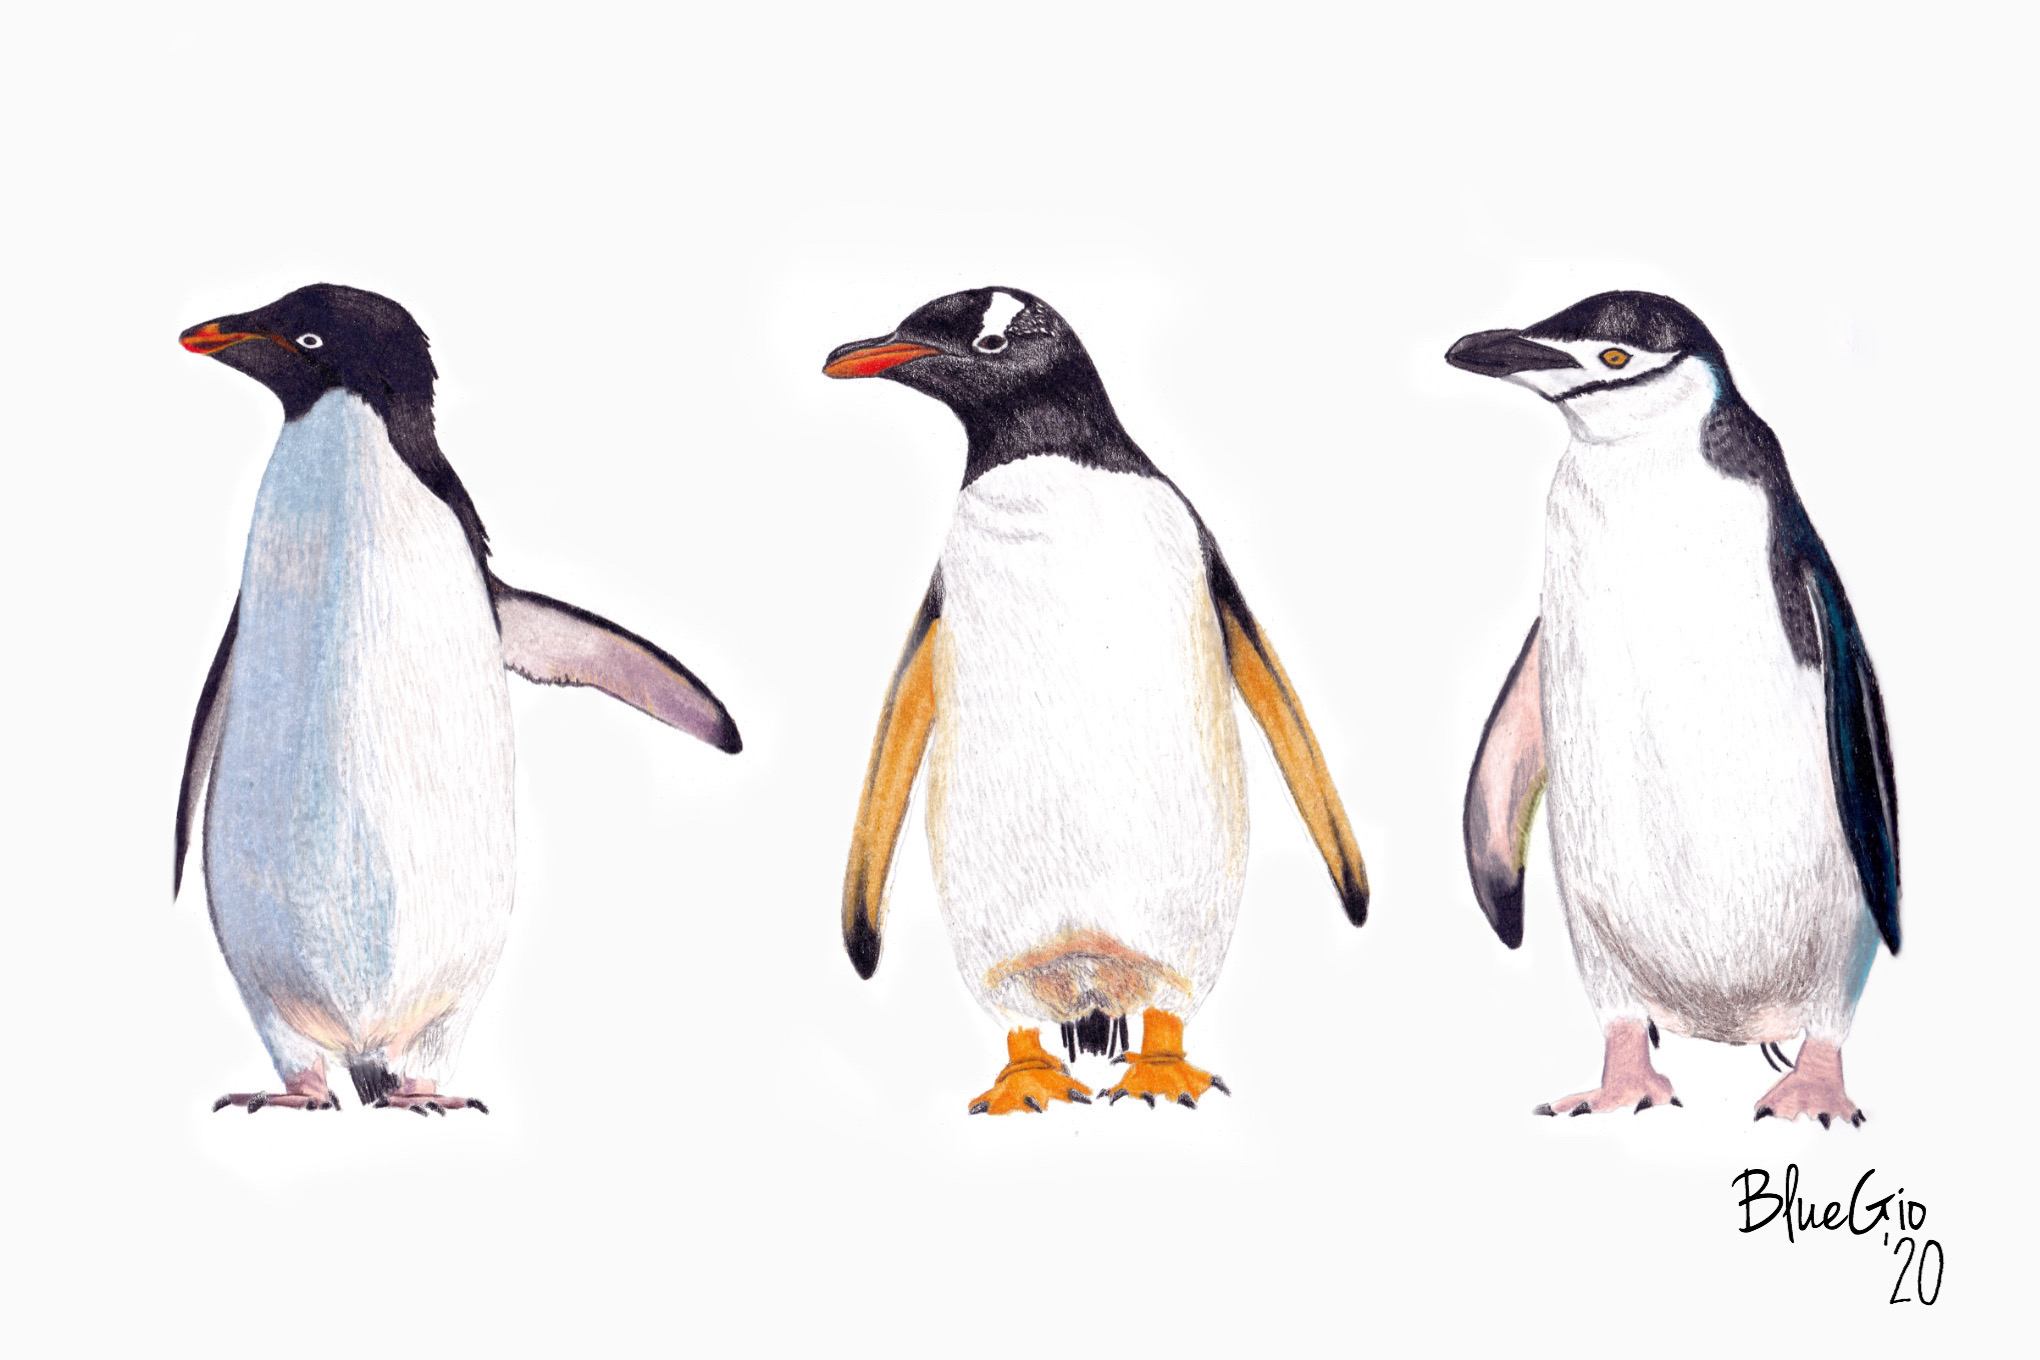

The goal: classify the different penguins based on the features in the dataset using pipelines, columntransformers, featureUnions.

First we will take a look at dealing with the missing data through imputation

## Importing and exploring the data

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np

In [ ]:
# Read the data

# First rows of the data


In [ ]:
# A description of the numerical columns of the dataset


In [ ]:
# How many rows have missing data?

# What collumns have missing data?


## Impute the missing data

### Simple imputing
Using a constant for categorical values or using the mean of the data for numerical values

In [ ]:
# Copy the dataset into a new variable, as to not lose the initial data
dataset_simple=dataset.copy()

# Import the simple imputer
# Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer
from sklearn.impute import SimpleImputer

# Initialize the imputer, don't add additional parameters (default SimpleImputer)


# Define the numerical columns to impute as a list: ["columnname1","columnname2"...]

# Impute the values as the mean of the column (this is the default strategy, will not work on categorical values)
# This can be done through the fit_transform function:
# df[numerical_columns] = simple_imputer.fit_transform(df[numerical values])

# "Impute" the categorical column "sex". Fill in "Unknown" if the value is missing
# For this, create a new SimpleImputer, and use the constant strategy and set the fill_value (see documentation)
# Don't set the missing_values parameter

# Imputer expects a 2D array (table), not a single column => reshape
# Example code:
dataset_simple.sex=imp_cat.fit_transform(dataset_simple.sex.values.reshape(-1,1))

In [ ]:
# Check how much rows have missing data now (should be 0, otherwise we forgot a collumn)


In [ ]:
# Let's take a look at the first rows of the data again. Previously missing data should have a value now!


### More complex KNN imputing (see also unsupervised learning)
Note: Only works for numerical data

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Copy the original dataset again (with missing data), as to not lose the original data

# Convert island to categorical number values, so that we can use it to impute when other data is missing
# For this: use the LabelEncoder, fit_transform the island column, and replace the original column with the new one


# Initialize/create the KNN imputer, use for example 3 for n_neighbors
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html?highlight=knnimputer#sklearn.impute.KNNImputer


# Define the numerical columns (now including the island column due to the previous step)
# impute the missing values for these columns (similar to simpleImputer)


# Fill in the na values in the sex column. Here, just use the df.fillna() function and fill "Unknown" in


In [ ]:
# Take a look at the data again


## Transform the categorical text data into categorical numerical data

In [ ]:
# Copy the imputed data that you want to use (from the simple imputer or the knn imputer)

# Example:
#dataset=dataset_simple.copy()
dataset=dataset_knn.copy()

In [ ]:
# Use the labelencoder to transform the remaining categorical columns to numerical ones


In [ ]:
# Split the data in X and y (=species)


In [ ]:
# Split into training and test set
from sklearn.model_selection import train_test_split


## Pipelines
Pipelines allow you to create a logical workflow for your data. It will apply them sequentially (output will be fed to the next step)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Create a pipeline that 
# first scales the data and
# predicts the class using a random forest classifier.
#     Use a max_depth of 2 and 20 estimators



# Fit the model on the training set, and print the score of the test set




In [ ]:
# Further test the model by predicting the test set and printing the classification_report and confusion_matrix

from sklearn.metrics import classification_report,confusion_matrix



## Columntransformers
In the pipeline above, we could not implement the imputing, because we had a mixture of numerical and categorical data which we need to preprocess seperately. This is not possible with a pipeline.

For this purpose, we have columntransformers, which will perform a transformation (a model that has a .fit and .transform function) only on the specified columns. Multiple pipelines can be run in parallel this way!

We will read in the data again, so we can also include our imputer and labelencoder/onehotencoder in the columntransformer

In [ ]:
# Read the data

# Display first rows


In [ ]:
# Split into features and targets and split into a train and test split


In [ ]:
# Create a list of the categorical column names
categorical = []
print(f"Categorical columns are: {categorical}")

# Do the same for the numerical columns
numerical = []
print(f"Numerical columns are: {numerical}")

In [ ]:
# Define the pipeline that should be used on the categorical columns

from sklearn.preprocessing import OneHotEncoder

# The pipeline should include following steps:
#    A simple imputer that fills in the missing values with "Unknown"
#    A one hot encoder with parameters handle_unknown='ignore' and sparse=False
cat_pipe = ...

# Define numerical pipeline
# The pipeline should include following steps:
#    A simple imputer with default settings (will take the mean of the column)
#    A standardscaler
from sklearn.preprocessing import StandardScaler
num_pipe = ...

from sklearn.compose import ColumnTransformer
# Create the column transformer with the pipeline for both numerical and categorical values
# ColumnTransformer accepts a list with a set for each pipeline.
# Each set contains the following 3 values: 
# ("A name for the step","The pipeline it should use", "A list of the columns it has to transform(defined in previous cell)")
preprocessor = ...



In [ ]:
# Because it is nice to take a look at the data when it is preprocessed:

# Fit the preprocessor we just created on the training data
preprocessor.fit(X_train)

# Get the names of the categorical columns after OneHotEncoder (since you will have a seperate column per classname)
# This can be done via the following code:
cat_columns = preprocessor.named_transformers_['cat']['encoder'].get_feature_names(categorical)
# Place them together with the numerical column names
columns = np.append(cat_columns, numerical)


# Create a new dataframe to display when we transform our training data, give the columns the names we determined above
display(pd.DataFrame(preprocessor.transform(X_train), columns=columns))

In [ ]:
# Finally fit a pipeline with our preprocessor (our columntransformer from before) and an estimator model 
# to the training data
# You can also use a random forest classifier for the estimator


# Fit the model on the training data

# Evaluating the model by taking a look at the metrics


## FeatureUnion
A feature union will basically act the same as a ColumnTransformer, with the exception that you can't directly select columns in the FeatureUnion definition, but you have to select the columns in the pipelines within the feature union.

In [ ]:
# Read the data in again. Split into features and targets and train and test split.

# If necessary, also define the categorical and numerical columns in a list for usage later on. The same as we did
# did above.


In [ ]:
# The select_columns class (object oriented python) accepts the columns you want to filter on, 
# and by calling fit and transform, it will return the specified columns

# BaseEstimator is an object with all the basic needs for an estimator in sklearn (internal mechanisms)
# TransformerMixin basically adds the fit_transform function to the class
from sklearn.base import BaseEstimator, TransformerMixin

# We create a class that inherits (gets the functionality) from the baseEstimator and also the TransformerMixin
class SelectColumns(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]

In [ ]:
# Let's test our class!

# Create our transformer (just like we would create a scaler, imputer, OHE...)
# We will select the categorical columns, which we defined two cells above this one. (feel free to swap out for numerical)
scolumn=SelectColumns(columns=categorical)
# Use the fit_transform function of this class (note that we didn't program this ourselves, this comes from TransfomerMixin)
scolumn.fit_transform(X_train)

In [ ]:
# Create the new workflow:
# Define the pipeline that should be used on the categorical columns
# Note we first have to "manually" select the columns with our custom transformer we created above
# Steps for the categorical pipeline:
#    - Select the categorical columns using the SelectColumns class
#    - Impute with simpleImputer (same as previously)
#    - One hot encode the categorical columns (same as previously)
cat_pipe = ...

# Define numerical pipeline
# Steps for the categorical pipeline:
#    - Select the numerical columns using the SelectColumns class
#    - Impute with simpleImputer (same as previously)
#    - Scale the numerical columns using standardscaler (same as previously)
num_pipe = ...

from sklearn.pipeline import FeatureUnion
# Create the FeatureUnion with the pipeline for both numerical and categorical values
# Similar as the columntransformer, but now, you don't have to specify the columns (we did this in the pipelines with the
# custom class)
preprocessor = ...

# Finally create and fit a pipeline with our preprocessor and an estimator model to the training data (Same as before)


# Evaluating the model by taking a look at the metrics
